# Model Evaluation

## Agenda

1. Null accuracy, handling missing values
2. Confusion matrix, sensitivity, specificity, setting a threshold
3. Handling categorical features, interpreting logistic regression coefficients
4. Cross-Validation

## Part 1: Null Accuracy, Handling Missing Values

Recall the Lab from last lesson on Logistic Regression. We will be revisting the ideas introduced using the Titanic dataset again.

For a description of the Titanic dataset see this Kaggle page: https://www.kaggle.com/c/titanic/data

In [38]:
# TASK 1: read the data from titanic.csv into a DataFrame
import pandas as pd
titanic = pd.read_csv('titanic.csv', index_col='PassengerId')

# TASK 2: define Pclass/Parch as the features and Survived as the response
feature_cols = ['Pclass', 'Parch']
X = titanic[feature_cols]
y = titanic.Survived
#X = ___
#y = ___

# TASK 3: split the data into training and testing sets
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# TASK 4: fit a logistic regression model
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

# TASK 5: make predictions on testing set and calculate accuracy
y_pred_class = logreg.predict(X_test)
from sklearn import metrics
print (metrics.accuracy_score(y_test, y_pred_class))

0.668161434978


### Null accuracy

Null accuracy is the accuracy that could be achieved by always predicting the **most frequent class**. It is a baseline against which you may want to measure your classifier.

In [3]:
# compute null accuracy manually
print (y_test.mean())
print (1 - y_test.mean())

0.4260089686098655
0.5739910313901345


In [5]:
# equivalent function in scikit-learn
# http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
from sklearn.dummy import DummyClassifier
dumb = DummyClassifier(strategy='most_frequent')
dumb.fit(X_train, y_train)
y_dumb_class = dumb.predict(X_test)
print (metrics.accuracy_score(y_test, y_dumb_class))

0.57399103139


### Handling missing values

scikit-learn models expect that all values are **numeric** and **hold meaning**. Thus, missing values are not allowed by scikit-learn.

One possible strategy is to just **drop missing values**:

In [6]:
# check for missing values
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [7]:
# drop rows with any missing values
titanic.dropna().shape

(183, 11)

In [8]:
# drop rows where Age is missing
titanic[titanic.Age.notnull()].shape

(714, 11)

Sometimes a better strategy is to **impute missing values**:

In [9]:
# fill missing values for Age with the mean age
titanic.Age.fillna(titanic.Age.mean(), inplace=True)

In [11]:
# equivalent function in scikit-learn, supports mean/median/most_frequent
from sklearn.preprocessing import Imputer
imp = Imputer(strategy='mean', axis=1)
titanic['Age'] = imp.fit_transform(titanic.Age.values.reshape(1,-1)).T

In [21]:
# include Age as a feature
feature_cols = ['Pclass', 'Parch', 'Age']
X = titanic[feature_cols]
y= titanic.Survived

from sklearn.model_selection import train_test_split
# TASK : split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# TASK : fit a logistic regression model
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)
# TASK : make predictions on testing set and calculate accuracy
y_pred_class = logreg.predict(X_test)

from sklearn import metrics

print (metrics.accuracy_score(y_test, y_pred_class))

0.67264573991


In [19]:
?LogisticRegression()

## Part 2: Confusion Matrix

In [25]:
# confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[107,  21],
       [ 52,  43]], dtype=int64)

For a plotting function that will plot a nice confusion matrix see: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [28]:
# %load confusion_matrix_nice.py
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
#from sklearn.model_selection import train_test_split # from sklearn version 0.18
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[107  21]
 [ 52  43]]


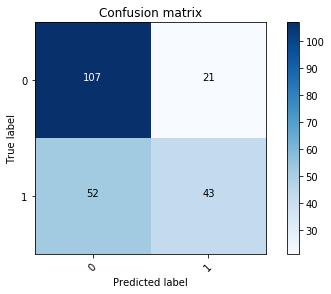

In [29]:
# plot an attractive confusion matrix
cnf_mat = metrics.confusion_matrix(y_test, y_pred_class, labels = titanic.Survived.unique())
class_labels = titanic.Survived.unique()
plt.figure()
plot_confusion_matrix(cnf_mat, class_labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

In [30]:
# calculate the sensitivity
43 / float(52 + 43)

0.45263157894736844

In [31]:
# calculate the specificity
107 / float(107 + 21)

0.8359375

In [35]:
# store the predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
print(y_pred_prob)

[ 0.52501831  0.19102245  0.52729118  0.19102245  0.72728774  0.24370353
  0.48165812  0.63755459  0.69316123  0.19102245  0.21832783  0.21228998
  0.47146153  0.41469676  0.19102245  0.69316123  0.44395889  0.22448847
  0.15861513  0.65259355  0.17863664  0.21228998  0.72270052  0.51837526
  0.28901424  0.20637503  0.82911305  0.31341415  0.44710389  0.73679475
  0.23717685  0.68009647  0.37984971  0.21832783  0.13831039  0.48839848
  0.62925612  0.19102245  0.71548155  0.25035087  0.20637503  0.30307953
  0.59700853  0.54723493  0.76769474  0.16344314  0.43515491  0.33693381
  0.63755459  0.53618973  0.41469676  0.49157997  0.50944763  0.36128971
  0.19491343  0.22448847  0.42077405  0.40988223  0.37984971  0.25035087
  0.28309917  0.19102245  0.49331602  0.5516586   0.70070964  0.28819752
  0.30161443  0.21228998  0.4510778   0.36289406  0.22448847  0.3486027
  0.54280378  0.19102245  0.2107695   0.46656123  0.63755459  0.19102245
  0.43604358  0.77622654  0.21228998  0.28309917  0.

Text(0,0.5,'Frequency')

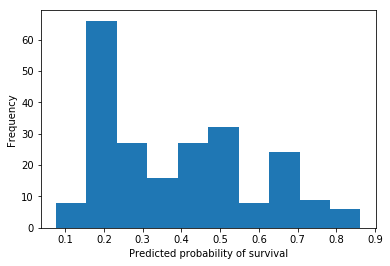

In [36]:
# plot the predicted probabilities
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(y_pred_prob)
plt.xlabel('Predicted probability of survival')
plt.ylabel('Frequency')

In [85]:
# change the threshold for predicting survived to increase sensitivity
import numpy as np
y_pred_class = np.where(y_pred_prob > 0.25, 1, 0)

In [86]:
print(y_pred_class)

[1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1
 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0
 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1
 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 0
 1 0 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1
 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0
 1]


In [89]:
# equivalent function in scikit-learn
from sklearn.preprocessing import binarize
y_pred_class = binarize(y_pred_prob.reshape(1,-1), 0.38).T

In [90]:
# new confusion matrix
print (metrics.confusion_matrix(y_test, y_pred_class))

[[81 47]
 [35 60]]


In [52]:
# new sensitivity
print (68 / float(27 + 68))

0.7157894736842105


In [53]:
# new specificity
print (57 / float(57 + 71))

0.4453125


## Part 3: Cross Validation Example on Bike Share

#### Intro to cross validation with bike share data

In [91]:
from sklearn import cross_validation
bikeshare = pd.read_csv('bikeshare.csv')

In [92]:
bikeshare.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [93]:
bikeshare.weathersit

0        1
1        1
2        1
3        1
4        1
5        2
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       2
14       2
15       2
16       2
17       2
18       3
19       3
20       2
21       2
22       2
23       2
24       2
25       2
26       2
27       2
28       2
29       3
        ..
17349    2
17350    1
17351    1
17352    1
17353    1
17354    1
17355    1
17356    1
17357    1
17358    1
17359    1
17360    1
17361    1
17362    1
17363    1
17364    2
17365    2
17366    2
17367    2
17368    2
17369    2
17370    2
17371    2
17372    2
17373    2
17374    2
17375    2
17376    1
17377    1
17378    1
Name: weathersit, Length: 17379, dtype: int64

#### Create dummy variables and set outcome (dependent) variable

In [72]:
weather = pd.get_dummies(bikeshare.weathersit, prefix='weather')
modeldata = bikeshare[['temp', 'hum']].join(weather[['weather_1', 'weather_2', 'weather_3']])
y = bikeshare.casual 

In [67]:
?pd.get_dummies(bikeshare.weathersit, prefix='weather')

#### Create a cross validation with 5 folds

In [77]:
kf = cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True)


In [82]:
from sklearn import linear_model

mse_values = []
scores = []
n= 0
print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1
    print ('Model', n)
    print ('MSE:', mse_values[n-1])
    print ('R2:', scores[n-1])


print ("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print ('Mean of MSE for all folds:', np.mean(mse_values))
print ('Mean of R2 for all folds:', np.mean(scores))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 1476.44325278
R2: 0.311844047013
Model 2
MSE: 1778.3217243
R2: 0.311908124803
Model 3
MSE: 1754.08922559
R2: 0.311909446363
Model 4
MSE: 1785.06173957
R2: 0.31192222063
Model 5
MSE: 1573.79021892
R2: 0.311868122269
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 1673.54123223
Mean of R2 for all folds: 0.311890392216


In [ ]:
lm = linear_model.LinearRegression().fit(modeldata, y)
print ("~~~~ Single Model ~~~~")
print ('MSE of single model:', metrics.mean_squared_error(y, lm.predict(modeldata)))
print ('R2: ', lm.score(modeldata, y))

### Check
While the cross validated approach here generated more overall error, which of the two approaches would predict new data more accurately: the single model or the cross validated, averaged one? Why?


Answer: 

## Part 4: Apply Cross Validation to the Titanic Dataset

In [ ]:
import pandas as pd
titanic = pd.read_csv('titanic.csv', index_col='PassengerId')

In [ ]:
titanic.head()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [ ]:
feature_cols = ['Pclass', 'Parch', 'Age']
X = titanic[feature_cols]
y = titanic.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logreg=LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)
zip(feature_cols, logreg.coef_[0])

In [ ]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=100)
print (scores)
print (scores.mean())

### Task: Evaluate each stage of the model with Cross-Validation

### Task: Evaluate the Cross-Validation score with different values of n (2, 5, 10, 50)

### Task: Experiment with differen model evaluation metrics form sci-kit learn

See a list of model evaluatin metrics here. Particulary try precision and recall and f1. Read about available methods and what they mean here:
http://scikit-learn.org/stable/modules/model_evaluation.html

